Need to get hourly or so BTC prices.  

Found this Stackoverflow thread:  
>Actually, you CAN get the whole Bitcoin trades history from Bitcoincharts in CSV format here : > http://api.bitcoincharts.com/v1/csv/

>it is updated twice a day for active exchanges, and there is a few dead exchanges, too.

>EDIT: Since there are no column headers in the CSVs, here's what they are : column 1) the trade's names=None, column 2) the price, column 3) the volume of the trade

  
Downloaded the data for bitstampUSD: 724 Mb unzipped csv.
Let's try

In [105]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import autopep8

In [2]:
# Matplotlib setup
from __future__ import print_function, division
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from plotly.offline import plot, iplot, init_notebook_mode
# import plotly.graph_objs as go

# # Make plotly work with Jupyter notebook
# %matplotlib inline
# init_notebook_mode()

# import cufflinks as cf

# Add error handler that installs cufflinks if this call above fails:
#  ! pip install cufflinks --upgrade

# cf.go_offline()

In [4]:
# Run once to fetch the data and filter it to 2017 only

# ADD CONDITION IF ISPATH to skip over this block

# Add the code to download and unzip the data from this URL:

# http://api.bitcoincharts.com/v1/csv/bitstampUSD.csv.gz (this is the 724Mb file)


# inp = pd.read_csv("data/bitstampUSD.csv",names = ["timestamp","price", "volume"])

# inp["date_time"]= pd.to_datetime(inp["timestamp"], unit='s')\
#                  .dt.tz_localize('UTC')\
#                  .dt.tz_convert('America/New_York')
        
# btc = inp[inp["date_time"]>= "2017-01-01"]
# btc.to_csv("processed_data/bitstampUSD_processed_2017.csv",index=False)
# btc.to_pickle("processed_data/bitstampUSD_processed_2017.p")

In [7]:
processed_path = "processed_data/bitstampUSD_processed_2017.p"
btc = pd.read_pickle(processed_path)

In [8]:
btc.head()

,timestamp,price,volume,date_time
10240699,1483228868,966.34,1.46000,2016-12-31 19:01:08-05:00
10240700,1483228873,966.34,1.32000,2016-12-31 19:01:13-05:00
10240701,1483228888,966.34,4.83000,2016-12-31 19:01:28-05:00
10240702,1483228926,966.16,2.38000,2016-12-31 19:02:06-05:00
10240703,1483228926,966.36,2.20029,2016-12-31 19:02:06-05:00


In [9]:
# Extract time components and initially inspect the dataset

btc["date"] = btc.date_time.dt.date
btc["hour"] = btc.date_time.dt.hour

In [10]:
# Add date time to index and cut out the end of 2016
btc.index = btc.date_time
btc = btc["2017"]

In [11]:
# btc_daily_avg = btc.groupby(["date"])["price"].mean()
# btc_daily_avg = pd.DataFrame(btc_daily_avg).reset_index() 
# btc_daily_avg.head()

In [12]:
# btc_hourly_avg = btc.groupby(["date", "hour"])['price'].mean()
# btc_hourly_avg = pd.DataFrame(btc_hourly_avg).reset_index() 
# btc_hourly_avg.head()

#### How did the price development look like in 2017?

In [13]:
# Make the daily/hourly plot
plt.figure(num=1, figsize=(16, 8)) 
plt.plot(btc_hourly_avg["date"], btc_hourly_avg["price"], linewidth=1,
         color="red", label=r"hourly avg price")
plt.xlabel(r"Date")
plt.ylabel(r"Avg BTC price (USD)")
plt.title(r"Daily/hourly average BTC price in 2017")


plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
         color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

NameError: name 'btc_hourly_avg' is not defined

#### Did the price increase or decrease at the close of the day?

In [15]:
btc_ohlc = btc.groupby("date")["price"].agg({"open" : "first","high": "max",
                                              "low":"min","close" : "last",
                                              "median":"median"})

conditions = [(btc_ohlc['open'] <= btc_ohlc['close'])
              ,(btc_ohlc['open'] > btc_ohlc['close'])
             ]
choices = ["up","down"]

btc_ohlc['price_change'] = np.select(conditions, choices)


/Users/dima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
btc_ohlc.head(10)

,open,high,low,close,median,price_change
date,,,,,,
2017-01-01,963.02,1005.75,962.80,1005.73,997.625,up
2017-01-02,1005.48,1032.00,990.01,1023.57,1014.920,up
2017-01-03,1023.59,1046.00,1009.08,1042.64,1020.290,up
2017-01-04,1042.34,1139.89,1038.35,1118.05,1090.980,up
2017-01-05,1118.05,1136.72,885.41,970.10,983.500,down
2017-01-06,969.92,989.97,821.22,836.74,894.860,down
2017-01-07,837.48,938.00,812.28,937.05,885.010,up
2017-01-08,938.00,941.81,875.00,884.65,908.340,down
2017-01-09,885.01,910.58,879.94,895.62,894.250,up


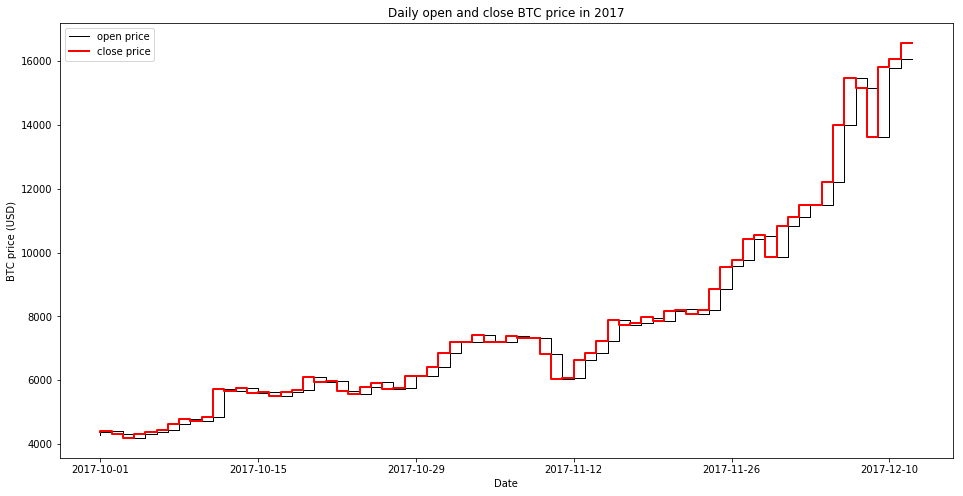

In [17]:
# Make the o-c plot
df = btc_ohlc[pd.to_datetime("2017-10-01").date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Daily open and close BTC price in 2017")

plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")

# plt.bar(x=df.index, height=df["close"], color = "grey", width = -0.4,align="center")
plt.legend(loc="upper left")

plt.show()

In [18]:
btc_ohlc.groupby("price_change").count()

,open,high,low,close,median
price_change,,,,,
down,130,130,130,130,130
up,216,216,216,216,216


In [19]:
btc["dt_6h"] = (pd.DatetimeIndex(btc['date_time'])).round("6H")

In [20]:
btc_ohlc_6h = btc.groupby("dt_6h")["price"].agg({"open" : "first","high": "max",
                                              "low":"min","close" : "last",
                                              "median":"median"})

/Users/dima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
conditions = [(btc_ohlc_6h['open'] <= btc_ohlc_6h['close'])
              ,(btc_ohlc_6h['open'] > btc_ohlc_6h['close'])
             ]
choices = ["up","down"]

btc_ohlc_6h['price_change'] = np.select(conditions, choices)
btc_ohlc_6h.groupby("price_change").count()

,open,high,low,close,median
price_change,,,,,
down,596,596,596,596,596
up,786,786,786,786,786


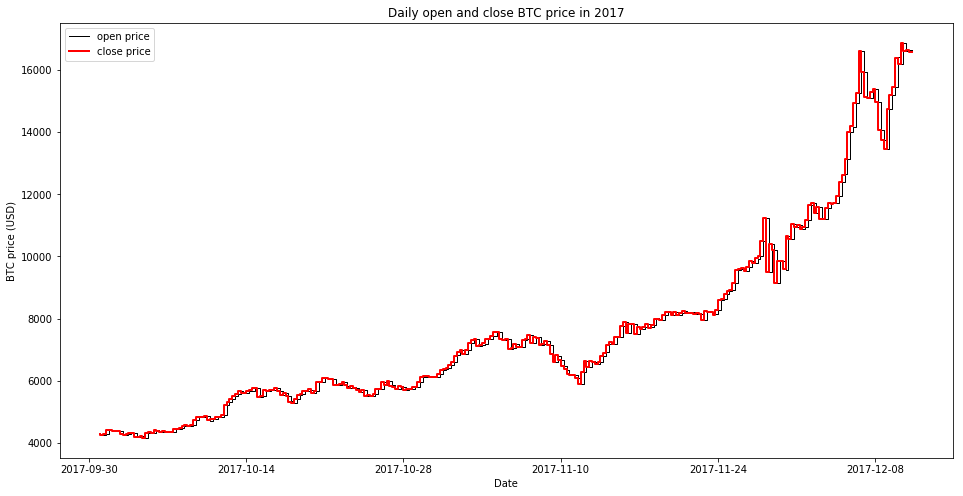

In [22]:
# Make the o-c plot
df = btc_ohlc_6h[pd.to_datetime("2017-10-01").date():]

plt.figure(num=1, figsize=(16, 8)) 
plt.step(df.index, df["open"], linewidth=1,
         color="black", label=r"open price")
plt.xlabel(r"Date")
plt.ylabel(r"BTC price (USD)")
plt.title(r"Daily open and close BTC price in 2017")

plt.step(df.index, df["close"], linewidth=2,
         color="red", label=r"close price")

# plt.bar(x=df.index, height=df["close"], color = "grey", width = -0.4,align="center")
plt.legend(loc="upper left")

plt.show()

In [23]:
btc_ohlc.to_csv("processed_data/btc_ohlc.csv")
btc_ohlc_6h.to_csv("processed_data/btc_ohlc_6h.csv")

### Get the Tweets

In [149]:
twt_path = "data/tweets2017.csv"
twt = pd.read_csv(twt_path)
twt.shape

(49212, 2)

In [150]:
twt.head(5)

,tweet,timestamp
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03


### Question to clarify - what is the timezone of the twitter timestamps? What is the timezone of the bitcoin price data?

#### Clean the tweets from URLS, non-english characters, and duplicates

In [151]:
def isEnglish(s):
    """Checks if a string contains ASCII characters only.
    Source: https://stackoverflow.com/a/27084708/8066374
    """
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [153]:
# Clean the tweets
twt["tweet_proc"] = twt["tweet"].str.replace("https?://.*","") # remove all urls
twt["tweet_proc"] = twt["tweet_proc"].str.replace("’|#","") # remove non-unicode apostrophe and also hashtag sign
twt = twt[twt["tweet_proc"].str.len() >= 3] # retain only the tweets with more than 3 remaining characters
twt["is_english"] = twt["tweet_proc"].map(isEnglish)

In [154]:
twt.head(5)

,tweet,timestamp,tweet_proc,is_english
0,Investment Firm Will Use Bitcoin To Avoid US S...,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,True
1,#Anarchist #Bitcoin Coder Amir Taaki Wound Up ...,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,True
2,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ ...,2017-03-31 21:04:50,【仮想通貨】日本版 Bitcoin 、Monacoinでできること - NAVER まとめ,False
3,How The Technology Behind Bitcoin Is Going To ...,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,True
4,Federal Reserve official warns of digital curr...,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,True


In [155]:
twt.groupby(["is_english"])["tweet"].count()

is_english
False     8404
True     39725
Name: tweet, dtype: int64

Removed 8404 tweets with non-ascii characters to prepare the data for VADER sentiment analysis

In [156]:
twt_clean = twt[twt["is_english"]==True]

In [157]:
twt_clean = twt_clean.drop_duplicates("tweet_proc")

In [158]:
twt_clean.shape

(21649, 4)

In [290]:
# twt_clean[twt_clean.date == "2017-12-02"]

AttributeError: Can only use .dt accessor with datetimelike values

Only 21.6k tweets remain after the cleaning step

#### Extract sentiment using NLTK and VADER

In [159]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [160]:
print(twt_clean.loc[3,'tweet_proc'])
print(sid.polarity_scores(twt_clean.loc[3,'tweet_proc']))

How The Technology Behind Bitcoin Is Going To Change The Lives Of The Bottom Billion 
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [161]:
twt_clean["sid"] = twt_clean["tweet_proc"].map(lambda x: sid.polarity_scores(x))

In [162]:
twt_clean = pd.concat([twt_clean.drop(["sid","tweet","is_english"], axis=1), 
                       twt_clean["sid"].apply(pd.Series)], axis=1)

In [166]:
twt_clean.head(10)

,timestamp,tweet_proc,compound,neg,neu,pos
0,2017-03-31 20:00:05,Investment Firm Will Use Bitcoin To Avoid US S...,-0.2960,0.180,0.820,0.000
1,2017-03-31 20:28:19,Anarchist Bitcoin Coder Amir Taaki Wound Up Fi...,-0.3612,0.152,0.848,0.000
3,2017-03-31 21:19:49,How The Technology Behind Bitcoin Is Going To ...,0.0000,0.000,1.000,0.000
4,2017-03-31 22:08:03,Federal Reserve official warns of digital curr...,-0.3612,0.368,0.632,0.000
5,2017-03-31 22:13:59,Bitcoin : 'Blood Diamonds' Of The Digital Era ...,0.1759,0.145,0.639,0.217
6,2017-03-31 22:18:00,A Plan to Save Blockchain Democracy From Bitco...,-0.1779,0.277,0.496,0.227
7,2017-03-31 22:30:18,Digital asset exchange ShapeShift raises $10.4...,0.3612,0.000,0.762,0.238
8,2017-03-31 22:31:14,How an Anarchist Bitcoin Coder Found Himself F...,-0.3612,0.200,0.800,0.000
11,2017-04-01 00:03:18,Reg now behind invisible HTML5 Bitcoin paywall,0.0000,0.000,1.000,0.000
13,2017-04-01 01:03:10,Rising value of ethereum Turning a corner? Is ...,0.4137,0.000,0.784,0.216


#### Visualize the daily sentiment over time

In [172]:
# Extract time components 
twt_clean["timestamp"] = pd.to_datetime(twt_clean["timestamp"] )
twt_clean["date"] = twt_clean["timestamp"].dt.date
twt_clean["hour"] = twt_clean["timestamp"].dt.hour

# Get daily total for the VADER scores
twt_clean_daily = twt_clean[["date","neg","pos","compound"]].groupby(["date"]).sum()
twt_clean_daily.head()

,neg,pos,compound
date,,,
2017-03-31,1.322,0.682,-1.0204
2017-04-01,5.521,6.834,2.4179
2017-04-02,3.353,6.134,4.6129
2017-04-03,3.313,8.558,7.8017
2017-04-04,6.125,8.656,1.3070


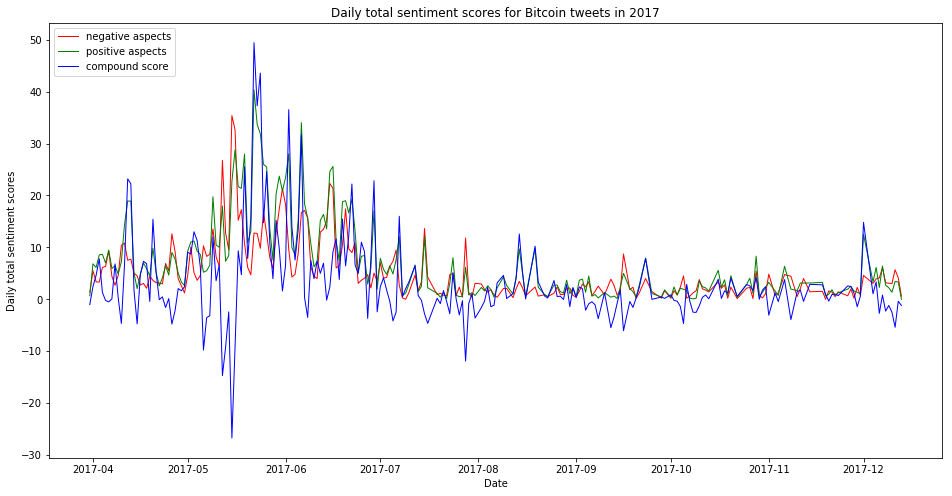

In [178]:
# Make a line plot
df = twt_clean_daily

plt.figure(num=1, figsize=(16, 8)) 
plt.plot(df.index, df["neg"], linewidth=1,
         color="red", label=r"negative aspects")
plt.plot(df.index, df["pos"], linewidth=1,
         color="green", label=r"positive aspects")
plt.plot(df.index, df["compound"], linewidth=1,
         color="blue", label=r"compound score")
plt.xlabel(r"Date")
plt.ylabel(r"Daily total sentiment scores")
plt.title(r"Daily total sentiment scores for Bitcoin tweets in 2017")


# plt.plot(btc_daily_avg["date"], btc_daily_avg["price"], linewidth=1,
#          color="blue", label=r"daily avg price")

plt.legend(loc="upper left")

plt.show()

#### Correlate the daily compound sentiment with the price change direction

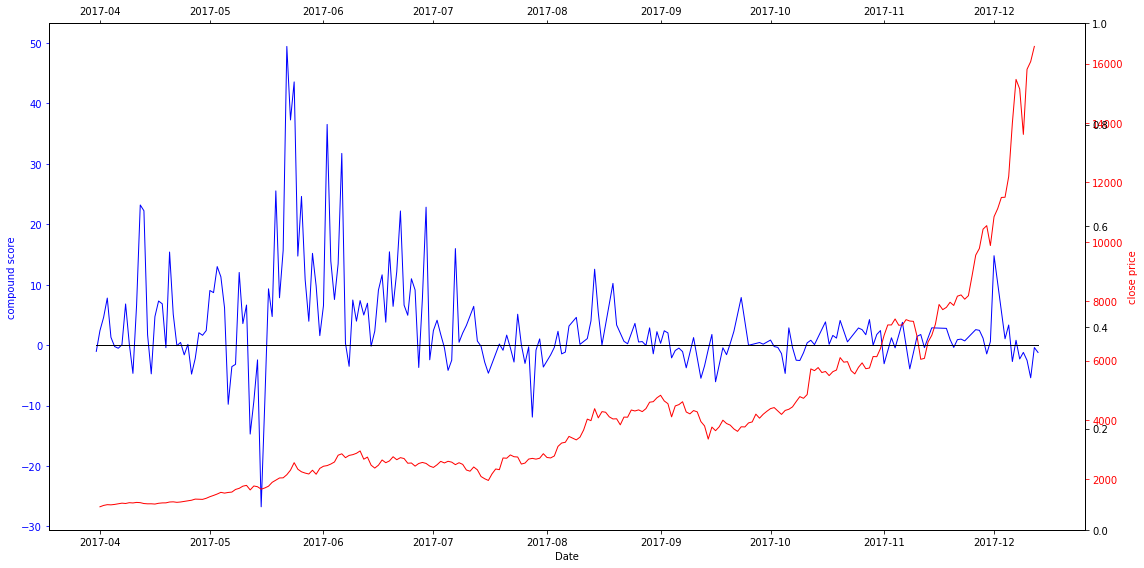

In [282]:
df1 = twt_clean_daily[pd.to_datetime("2017-04-01").date():]
df2 = btc_ohlc[pd.to_datetime("2017-04-01").date():]

fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(twt_clean_daily.index, twt_clean_daily["compound"], linewidth=1,color="blue")
ax1.set_xlabel('Date')

# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('compound score', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()

ax2.plot(df2.index, df2["close"], linewidth=1,color="red")
ax2.set_ylabel('close price', color='red')
ax2.tick_params('y', colors='red')

ax3 = ax1.twinx()
ax3 = ax1.twiny()
ax3.plot(twt_clean_daily.index,np.repeat(0,len(twt_clean_daily.index)),
         linewidth=1,color="black")

fig.tight_layout()
plt.show()

In [283]:
print(df1.head(1))
print(df2.head(1))

              neg    pos  compound
date                              
2017-04-01  5.521  6.834    2.4179
               open    high      low    close   median price_change
date                                                               
2017-04-01  1069.15  1097.0  1061.64  1074.77  1075.35           up


In [284]:
btc_twt = pd.merge(df2.reset_index(),df1.reset_index(),"left")
btc_twt.shape

(256, 10)

In [285]:
btc_twt.tail(20)

,date,open,high,low,close,median,price_change,neg,pos,compound
236,2017-11-23,8214.91,8270.00,7876.00,8066.52,8140.51,down,1.425,1.250,0.7140
237,2017-11-24,8066.00,8340.00,8032.24,8183.56,8200.00,up,NaN,NaN,NaN
238,2017-11-25,8187.80,8870.85,8160.90,8852.47,8597.66,up,NaN,NaN,NaN
239,2017-11-26,8852.47,9597.78,8758.34,9550.01,9184.99,up,0.669,1.963,2.5794
240,2017-11-27,9564.40,9777.00,9267.00,9777.00,9581.46,up,1.979,2.501,2.4607
241,2017-11-28,9776.00,10438.00,9723.64,10424.95,9890.00,up,0.184,1.570,1.1589
242,2017-11-29,10417.90,11395.00,9250.00,10543.97,10400.50,up,2.298,1.371,-1.4389
243,2017-11-30,10511.52,10581.95,9000.00,9872.94,9750.00,down,0.767,1.045,0.5903
244,2017-12-01,9872.94,11082.00,9370.11,10844.72,10555.61,up,4.597,12.537,14.8126
245,2017-12-02,10844.06,11200.00,10637.69,11118.17,10924.80,up,NaN,NaN,NaN


In [286]:
btc_twt[btc_twt.pos.isnull()]

,date,open,high,low,close,median,price_change,neg,pos,compound
101,2017-07-11,2313.25,2399.00,2239.54,2273.47,2335.220,down,NaN,NaN,NaN
107,2017-07-17,1961.26,2229.97,1956.91,2182.99,2122.000,up,NaN,NaN,NaN
108,2017-07-18,2179.07,2392.00,2170.12,2347.97,2301.890,up,NaN,NaN,NaN
122,2017-08-01,2862.92,2929.17,2615.00,2734.76,2727.840,down,NaN,NaN,NaN
129,2017-08-08,3446.00,3490.00,3300.00,3384.67,3420.000,down,NaN,NaN,NaN
132,2017-08-11,3419.93,3705.00,3410.78,3662.51,3529.955,up,NaN,NaN,NaN
138,2017-08-17,4279.35,4480.00,4167.21,4258.92,4313.990,down,NaN,NaN,NaN
139,2017-08-18,4263.11,4368.00,3964.96,4103.49,4172.670,down,NaN,NaN,NaN
142,2017-08-21,4031.66,4080.00,3810.25,3835.10,3996.050,down,NaN,NaN,NaN
145,2017-08-24,4099.94,4373.84,4082.59,4334.38,4211.430,up,NaN,NaN,NaN


In [279]:
btc_twt["price_change_next_day"] = btc_twt["price_change"].shift(-1)

### There are some days with no tweets in our dataset: decide what to do - remove or impute!

In [239]:
# Filter out the days with no twitter sentiment
btc_twt = btc_twt.dropna()
btc_twt.shape

(221, 10)

221 daily observations remain if NaN twitter days are ignored

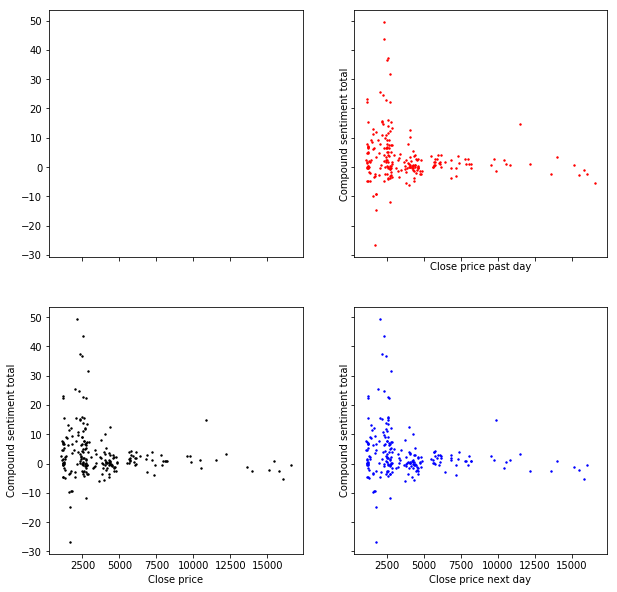

In [258]:
df = btc_twt

# fig, ax1 = plt.subplots(figsize=(8, 8))
fig, ((ax1, ax2), (ax1, ax3)) = plt.subplots(2,2, sharex=True, sharey=True,figsize=(10, 10))
ax1.scatter(df["close"], df["compound"], color="black",s=2)
ax1.set_xlabel('Close price')
ax1.set_ylabel('Compound sentiment total')

ax2.scatter(df["close"], df["compound"].shift(1), color="red",s=2)
ax2.set_xlabel('Close price past day')
ax2.set_ylabel('Compound sentiment total')

ax3.scatter(df["close"], df["compound"].shift(-1), color="blue",s=2)
ax3.set_xlabel('Close price next day')
ax3.set_ylabel('Compound sentiment total')

plt.show()

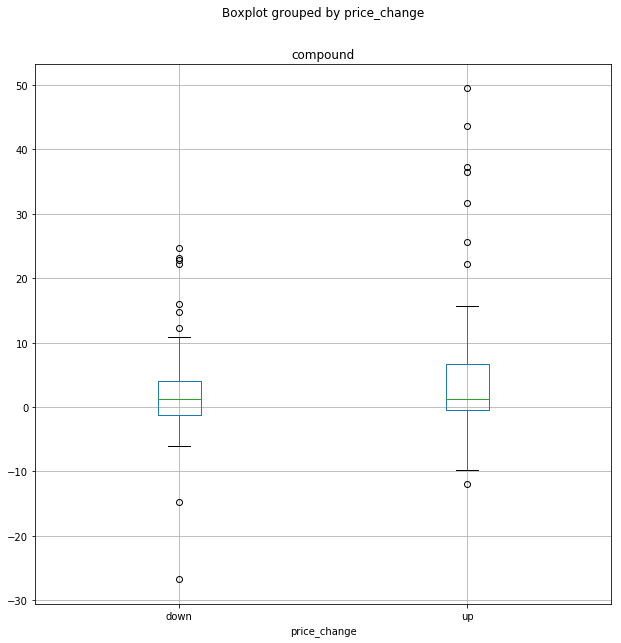

In [293]:
# btc_twt["price_change_next_day"]
btc_twt.boxplot(column='compound',by='price_change',figsize=(10, 10))

In [255]:
pd.concat([df["compound"],df["compound"].shift(-1),df["compound"].shift(1) ],axis=1)

,compound,compound,compound
0,2.4179,4.6129,NaN
1,4.6129,7.8017,2.4179
2,7.8017,1.3070,4.6129
3,1.3070,-0.2184,7.8017
4,-0.2184,-0.5042,1.3070
5,-0.5042,0.0730,-0.2184
6,0.0730,6.8248,-0.5042
7,6.8248,0.2680,0.0730
8,0.2680,-4.6592,6.8248
9,-4.6592,6.6597,0.2680


### Next steps
  
Dima  
1. Get numeric feature for the price (rolling X hours) - daily and time-period (make function)

Liam
2. Get more Twitter data (to close the days with the gaps) - try switching off Top Tweets
3. Get more Twitter data - from "news" 

Tomorrow
4. Inspect correlations between sentiment and price response (also time-shifted)
5. Maybe - if we see correlation - come up with a model to predict the response

Optional
1. Word frequency distribution from the tweets (also separately for positive and negative tweets)

### Reference

https://pandas.pydata.org/pandas-docs/stable/index.html  
http://mple.m-artwork.eu/tutorial  
Pandas Ifelse selection https://stackoverflow.com/a/19913845/8066374  
NLTK & Vader http://www.nltk.org/howto/sentiment.html  
Pandas dict to columns https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns  
Matplotlib multiple axes https://matplotlib.org/examples/api/two_scales.html